In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from keras.optimizers import Adam
from keras_nlp.layers import PositionEmbedding

In [15]:
seed = 50

np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [16]:
def bert_module(query, key, value, embed_dim, num_head, i):
    
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_head,
        key_dim=embed_dim // num_head,
        name="encoder_{}/multiheadattention".format(i)
    )(query, key, value, use_causal_mask=True)
    
    # Add & Normalize
    attention_output = layers.Add()([query, attention_output])  # Skip Connection
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)
    
    # Feedforward network
    ff_net = keras.models.Sequential([
        layers.Dense(2 * embed_dim, activation='relu', name="encoder_{}/ffn_dense_1".format(i)),
        layers.Dense(embed_dim, name="encoder_{}/ffn_dense_2".format(i)),
    ])

    # Apply Feedforward network
    ffn_output = ff_net(attention_output)

    # Add & Normalize
    ffn_output = layers.Add()([attention_output, ffn_output])  # Skip Connection
    ffn_output = layers.LayerNormalization(epsilon=1e-6)(ffn_output)
    
    return ffn_output

In [17]:
def get_sinusoidal_embeddings(sequence_length, embedding_dim):
    position_enc = np.array([
        [pos / np.power(10000, 2. * i / embedding_dim) for i in range(embedding_dim)]
        if pos != 0 else np.zeros(embedding_dim)
        for pos in range(sequence_length)
    ])
    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2])  # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2])  # dim 2i+1
    return tf.cast(position_enc, dtype=tf.float32)

In [18]:
def insert_element_randomly(my_list, element):
    
    if len(my_list) > 1:

        index = random.randint(0, 2)
        
    else:
        
        index = 0

    new_list = my_list[:(4 * index)] + element + my_list[(4 * index):]
    
    return new_list

In [19]:
N = 20 # vocab_size
M = 20 # number of random words

vocabs = ['word_' + str(i) for i in range(N)] + ['random_' + str(i) for i in range(M)]

vocabs_word = ['word_' + str(i) for i in range(N)]

vocab_map = {}
for i in range(len(vocabs)):
    vocab_map[vocabs[i]] = i

In [20]:
pairs = []

for i in vocabs_word:
    for j in vocabs_word:
        for k in vocabs_word:
            if i != j and i != k and j != k:
                pairs.append((i,j,k))

indicator = np.random.choice([0, 1], size=len(pairs), p=[0.5, 0.5])

pairs_train = [pairs[i] for i in range(len(indicator)) if indicator[i] == 1]
pairs_test = [pairs[i] for i in range(len(indicator)) if indicator[i] == 0]

sentences_train = []
sentences_number_train = []
sentences_test_a = []
sentences_number_test_a = []
sentences_test_b = []
sentences_number_test_b = []

x_masked_train = []
y_masked_labels_train = []
x_masked_test_a = []
y_masked_labels_test_a = []
x_masked_test_b = []
y_masked_labels_test_b = []

for _ in range(25000):

    random_words = random.sample(['random_' + str(i) for i in range(M)], 4)

    [(a,b,c), (d,e,f)] = random.sample(pairs_train, 2)

    temp = [a, b, c, a, d, e, f, d]
    temp = insert_element_randomly(temp, random_words)

    sentences_train.append(temp)
    sentences_number_train.append([vocab_map[i] for i in temp])
    x_masked_train.append([vocab_map[i] for i in temp])
    y_masked_labels_train.append([vocab_map[i] for i in temp][1:])

    random_words = random.sample(['random_' + str(i) for i in range(M)], 4)

    [(a,b,c), (d,e,f)] = random.sample(pairs_train, 2)

    temp = [a, b, c, b, d, e, f, e]
    temp = insert_element_randomly(temp, random_words)

    sentences_train.append(temp)
    sentences_number_train.append([vocab_map[i] for i in temp])
    x_masked_train.append([vocab_map[i] for i in temp])
    y_masked_labels_train.append([vocab_map[i] for i in temp][1:])



for _ in range(25000):

    [(a,b,c), (d,e,f), (g,h,i)] = random.sample(pairs_test, 3)

    temp = [a, b, c, a, d, e, f, d, g, h, i, g]

    sentences_test_a.append(temp)
    sentences_number_test_a.append([vocab_map[i] for i in temp])
    x_masked_test_a.append([vocab_map[i] for i in temp])
    y_masked_labels_test_a.append([vocab_map[i] for i in temp][1:])

    [(a,b,c), (d,e,f), (g,h,i)] = random.sample(pairs_test, 3)

    temp = [a, b, c, b, d, e, f, e, g, h, i, h]

    sentences_test_b.append(temp)
    sentences_number_test_b.append([vocab_map[i] for i in temp])
    x_masked_test_b.append([vocab_map[i] for i in temp])
    y_masked_labels_test_b.append([vocab_map[i] for i in temp][1:])

x_masked_train = np.array(x_masked_train)
y_masked_labels_train = np.array(y_masked_labels_train)
x_masked_test_a = np.array(x_masked_test_a)
y_masked_labels_test_a = np.array(y_masked_labels_test_a)
x_masked_test_b = np.array(x_masked_test_b)
y_masked_labels_test_b = np.array(y_masked_labels_test_b)

perm = np.random.permutation(len(x_masked_train))
x_masked_train = x_masked_train[perm]
y_masked_labels_train = y_masked_labels_train[perm]

x_masked_train = x_masked_train[:,:-1]
x_masked_test_a = x_masked_test_a[:,:-1]
x_masked_test_b = x_masked_test_b[:,:-1]

In [21]:
x_masked_train[0]

array([ 7,  3,  2,  3,  2, 18,  9, 18, 36, 24, 27])

In [22]:
y_masked_labels_train[0]

array([ 3,  2,  3,  2, 18,  9, 18, 36, 24, 27, 34])

In [23]:
# Building the model

embed_dim = 100
num_heads = 2
num_blocks = 5

batch_size = 1024

input_layer = layers.Input(shape=(x_masked_train.shape[1],), dtype=tf.int32)  # Input layer

embedding_layer = layers.Embedding(M + N, embed_dim, name="word_embedding")(input_layer)  # Embedding layer
position_embeddings = PositionEmbedding(sequence_length=len(x_masked_train[0]))(embedding_layer)
embedding_layer = embedding_layer + position_embeddings

# Transformer blocks with causal masking for next token prediction
x = embedding_layer
for i in range(num_blocks):
    # Apply the causal mask to ensure that each position can only attend to known tokens
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads
    )(x, x, x, use_causal_mask=True)
    
    x = layers.Add()([x, attention_output])  # Skip Connection
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    ff_net = keras.models.Sequential([
        layers.Dense(2 * embed_dim, activation='relu'),
        layers.Dense(embed_dim),
    ])

    # Apply Feedforward network
    x = ff_net(x)

    # Add & Normalize
    x = layers.Add()([attention_output, x]) 
    x = layers.LayerNormalization(epsilon=1e-6)(x)

# Output layer for providing predictions over the vocabulary
predict_layer = layers.Dense(M + N, activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=predict_layer)  # Model definition
model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Compile the model

# Reshape the target data to have an extra dimension
y_masked_labels_train_reshaped = y_masked_labels_train.reshape(y_masked_labels_train.shape[0], 
                                                               y_masked_labels_train.shape[1], 1)

In [24]:
x_test_subset_a = x_masked_test_a[np.random.choice(x_masked_test_a.shape[0], size=500, replace=False)]
x_test_subset_b = x_masked_test_b[np.random.choice(x_masked_test_b.shape[0], size=500, replace=False)]

In [25]:
acc_a_list = []
acc_a_oo_list = []
prob_a_list = []

acc_b_list = []
acc_b_oo_list = []
prob_b_list = []

for _ in range(80):
    
    history = model.fit(x_masked_train, y_masked_labels_train_reshaped, epochs=5, batch_size=batch_size)
    
    acc_a = []
    acc_a_oo = []
    prob_a = []

    for sentence_number in x_test_subset_a:
        temp = keras.backend.function(inputs = model.layers[0].input, outputs = model.layers[-1].output) \
            (np.array(sentence_number).reshape(1,len(sentence_number)))
        temp = temp[:,-1,:]
        acc_a.append(1 if temp.argmax() == sentence_number[-3] else 0)
        acc_a_oo.append(1 if temp.argmax() == sentence_number[-3] or temp.argmax() == sentence_number[-2] else 0)
        prob_a.append(temp[0][sentence_number[-3]])

    acc_b = []
    acc_b_oo = []
    prob_b = []

    for sentence_number in x_test_subset_b:
        temp = keras.backend.function(inputs = model.layers[0].input, outputs = model.layers[-1].output) \
            (np.array(sentence_number).reshape(1,len(sentence_number)))
        temp = temp[:,-1,:]
        acc_b.append(1 if temp.argmax() == sentence_number[-2] else 0)
        acc_b_oo.append(1 if temp.argmax() == sentence_number[-2] or temp.argmax() == sentence_number[-3] else 0)
        prob_b.append(temp[0][sentence_number[-2]])
        
    acc_a_list.append(np.mean(acc_a))
    acc_a_oo_list.append(np.mean(acc_a_oo))
    prob_a_list.append(np.mean(prob_a))

    acc_b_list.append(np.mean(acc_b))
    acc_b_oo_list.append(np.mean(acc_b_oo))
    prob_b_list.append(np.mean(prob_b))

Epoch 1/5
49/49 [==============================] - 20s 269ms/step - loss: 3.6608 - accuracy: 0.0336
Epoch 2/5
49/49 [==============================] - 14s 279ms/step - loss: 3.5898 - accuracy: 0.0358
Epoch 3/5
49/49 [==============================] - 14s 281ms/step - loss: 3.0887 - accuracy: 0.0487
Epoch 4/5
49/49 [==============================] - 13s 275ms/step - loss: 3.0431 - accuracy: 0.0497
Epoch 5/5
49/49 [==============================] - 14s 278ms/step - loss: 3.0448 - accuracy: 0.0516
Epoch 1/5
49/49 [==============================] - 14s 282ms/step - loss: 3.0481 - accuracy: 0.0503
Epoch 2/5
49/49 [==============================] - 14s 285ms/step - loss: 3.0297 - accuracy: 0.0572
Epoch 3/5
49/49 [==============================] - 14s 282ms/step - loss: 2.9072 - accuracy: 0.0956
Epoch 4/5
49/49 [==============================] - 14s 284ms/step - loss: 2.7109 - accuracy: 0.1287
Epoch 5/5
49/49 [==============================] - 14s 280ms/step - loss: 2.6425 - accuracy: 0.1357


49/49 [==============================] - 13s 262ms/step - loss: 2.0972 - accuracy: 0.3262
Epoch 5/5
49/49 [==============================] - 13s 262ms/step - loss: 2.0970 - accuracy: 0.3253
Epoch 1/5
49/49 [==============================] - 13s 265ms/step - loss: 2.0994 - accuracy: 0.3261
Epoch 2/5
49/49 [==============================] - 13s 261ms/step - loss: 2.0926 - accuracy: 0.3273
Epoch 3/5
49/49 [==============================] - 13s 263ms/step - loss: 2.0933 - accuracy: 0.3272
Epoch 4/5
49/49 [==============================] - 13s 264ms/step - loss: 2.0895 - accuracy: 0.3285
Epoch 5/5
49/49 [==============================] - 13s 261ms/step - loss: 2.0875 - accuracy: 0.3283
Epoch 1/5
49/49 [==============================] - 13s 256ms/step - loss: 2.0887 - accuracy: 0.3293
Epoch 2/5
49/49 [==============================] - 13s 264ms/step - loss: 2.0852 - accuracy: 0.3300
Epoch 3/5
49/49 [==============================] - 13s 258ms/step - loss: 2.0853 - accuracy: 0.3298
Epoch 4/5


49/49 [==============================] - 13s 258ms/step - loss: 1.9894 - accuracy: 0.3607
Epoch 2/5
49/49 [==============================] - 13s 258ms/step - loss: 1.9850 - accuracy: 0.3619
Epoch 3/5
49/49 [==============================] - 13s 259ms/step - loss: 1.9832 - accuracy: 0.3628
Epoch 4/5
49/49 [==============================] - 13s 261ms/step - loss: 1.9835 - accuracy: 0.3626
Epoch 5/5
49/49 [==============================] - 13s 259ms/step - loss: 1.9858 - accuracy: 0.3617
Epoch 1/5
49/49 [==============================] - 13s 260ms/step - loss: 1.9852 - accuracy: 0.3615
Epoch 2/5
49/49 [==============================] - 13s 261ms/step - loss: 1.9847 - accuracy: 0.3624
Epoch 3/5
49/49 [==============================] - 13s 257ms/step - loss: 1.9830 - accuracy: 0.3625
Epoch 4/5
49/49 [==============================] - 13s 258ms/step - loss: 1.9804 - accuracy: 0.3638
Epoch 5/5
49/49 [==============================] - 13s 255ms/step - loss: 1.9809 - accuracy: 0.3631
Epoch 1/5


49/49 [==============================] - 13s 258ms/step - loss: 1.9271 - accuracy: 0.3801
Epoch 4/5
49/49 [==============================] - 13s 264ms/step - loss: 1.9266 - accuracy: 0.3803
Epoch 5/5
49/49 [==============================] - 13s 261ms/step - loss: 1.9279 - accuracy: 0.3794
Epoch 1/5
49/49 [==============================] - 13s 263ms/step - loss: 1.9286 - accuracy: 0.3797
Epoch 2/5
49/49 [==============================] - 13s 260ms/step - loss: 1.9295 - accuracy: 0.3794
Epoch 3/5
49/49 [==============================] - 13s 261ms/step - loss: 1.9267 - accuracy: 0.3807
Epoch 4/5
49/49 [==============================] - 13s 262ms/step - loss: 1.9239 - accuracy: 0.3814
Epoch 5/5
49/49 [==============================] - 13s 260ms/step - loss: 1.9267 - accuracy: 0.3802
Epoch 1/5
49/49 [==============================] - 13s 266ms/step - loss: 1.9236 - accuracy: 0.3810
Epoch 2/5
49/49 [==============================] - 13s 264ms/step - loss: 1.9225 - accuracy: 0.3816
Epoch 3/5


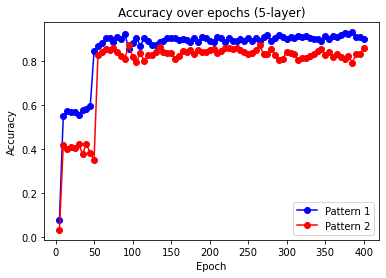

In [26]:
import matplotlib.pyplot as plt

epoch_intervals = range(5, 5 * (len(acc_a_list) + 1), 5) 

plt.plot(epoch_intervals, acc_a_list, label='Pattern 1', color='blue', marker='o') # 'marker' adds a marker at each data point
plt.plot(epoch_intervals, acc_b_list, label='Pattern 2', color='red', marker='o') # 'marker' adds a marker at each data point

# Adding legend to the plot
plt.legend()

# Title and labels
plt.title('Accuracy over epochs (5-layer)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


# Show the plot on the screen
plt.show()